### LOAD PACKAGES 

In [40]:
# Importation des librairies 

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import time

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score,classification_report,roc_auc_score,precision_score,recall_score, precision_recall_fscore_support 
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_som.som import SOM



pd.set_option('display.max_columns', 100)

### READ THE DATA 

In [41]:
# Lire la data stockée dans le fichier CSV. Modifier le chemin si vous relancer le kernel 
#df=pd.read_csv(r'C:\Users\anas.sory\Documents\Stage\creditcard.csv')
#train_df=pd.read_csv(r'C:\Users\MohamedAliELBOURI\Desktop\Projet\fraude-main\fraude-main\Data\archive fraude CB7\fraudTrain.csv')
#test_df=pd.read_csv(r'C:\Users\MohamedAliELBOURI\Desktop\Projet\fraude-main\fraude-main\Data\archive fraude CB7\fraudTest.csv')
import os
data_file= os.path.abspath('../../data')
full_path=data_file+'\\'+'fraudTrain.csv'
train_df=pd.read_csv(full_path)
full_path=data_file+'\\'+'fraudTest.csv'
test_df=pd.read_csv(full_path)

full_path=data_file+'\\'+'X_train_1_2_svm.csv'
xtrain_transformed_complique=pd.read_csv(full_path)
ytrain_transformed_complique=train_df['is_fraud'].iloc[:int(len(train_df)*0.8)]

full_path=data_file+'\\'+'X_test_1_2_svm.csv'
xtest_transformed_complique=pd.read_csv(full_path)
ytest_transformed_complique=test_df['is_fraud']

### CHECK THE DATA 

In [42]:
print(ytrain_transformed_complique.shape)
print(xtrain_transformed_complique.shape)

(1037340,)
(1037340, 32)


In [43]:
print("Credit Card Fraud Detection data -  rows:",train_df.shape[0]," columns:", train_df.shape[1])

Credit Card Fraud Detection data -  rows: 1296675  columns: 23


### Preparing and splitting the data

In [44]:
cols = train_df.columns.tolist()
cols = [c for c in cols if c not in ["is_fraud"]]
target = "is_fraud"
print(cols)

#Definition des nouvelles variables X_train and Y_train
X_train = train_df[cols]
Y_train = train_df[target]

#Definition des nouvelles variables X_test and Y_test
X_test = test_df[cols]
Y_test = test_df[target]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']
(1296675, 22)
(1296675,)
(555719, 22)
(555719,)


### Clustering Original data and finding outliers (with feature selection)

#### Preprocessing the data

In [45]:
# Defining selected features
features = [ 'category', 'gender', 'dob', 'city_pop', 'zip', 'amt', 'unix_time']
 #job contains unkonwn values in test
 #merchant and state too many values

X_train = X_train[features]
X_test = X_test[features]



In [46]:
# Inspecting categorical variables
#for col in X_train.columns:
#    if X_train[col].dtype == 'object':
#        print("-------------------------------------")
#        print(col)
#        print(np.unique(X_train[col].astype(str)))

In [47]:
category_to_label = {'misc_net' : 0, 'shopping_net' : 0, 'grocery_net' : 0,
                 'entertainment' : 1, 'personal_care' : 1, 'travel' : 1, 'shopping_pos':1,
                  'health_fitness' : 2, 'food_dining' : 2, 'misc_pos' : 2,
                    'gas_transport' : 3, 'grocery_pos' : 3, 'home' : 3, 'kids_pets' : 3
}
# 0 net
# 1 non essential
# 2 semi essential
# 3 essential 
categories = np.unique(X_train['category'].astype(str))
replace_list = [category_to_label[cat] for cat in categories]
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()
X_train_transformed['category'] = X_train['category'].replace(categories, replace_list)
X_test_transformed['category'] = X_test['category'].replace(categories, replace_list)

# Convert gender to binary
X_train_transformed['gender'] = X_train['gender'].replace(['M','F'], [0,1])
X_test_transformed['gender'] = X_test['gender'].replace(['M','F'], [0,1])

# Define age
from datetime import date
from datetime import datetime

def calculateAge(birthDate):
    birthDate = datetime.strptime(birthDate, '%Y-%m-%d').date()
    today = date.today()
    age = today.year - birthDate.year - ((today.month, today.day) <(birthDate.month, birthDate.day))
    return age

X_train_transformed['dob'] = X_train_transformed['dob'].apply(calculateAge)
X_test_transformed['dob'] = X_test_transformed['dob'].apply(calculateAge)

# retirer les columns xtrain
print(xtrain_transformed_complique.columns)
cols = [col for col in xtrain_transformed_complique.columns if col not in features]
cols.remove('Unnamed: 0')
xtrain_transformed_complique = xtrain_transformed_complique[cols]
xtest_transformed_complique=xtest_transformed_complique[cols]
print(xtrain_transformed_complique.columns)




Index(['Unnamed: 0', 'merchant', 'category', 'amt', 'gender', 'state', 'zip',
       'lat', 'long', 'city_pop', 'dob', 'unix_time', 'merch_lat',
       'merch_long', 'delta_time', 'delta_amt', 'delta_time_category',
       'delta_amt_category', 'delta_time_merchant', 'delta_amt_merchant',
       'avg_amt', 'delta_avg_amt', 'avg_amt_category',
       'delta_avg_amt_category', 'avg_amt_merchant', 'avg_amt_state',
       'avg_amt_city', 'avg_amt_job', 'delta_avg_amt_category_job', 'month',
       'day', 'hour'],
      dtype='object')
Index(['merchant', 'state', 'lat', 'long', 'merch_lat', 'merch_long',
       'delta_time', 'delta_amt', 'delta_time_category', 'delta_amt_category',
       'delta_time_merchant', 'delta_amt_merchant', 'avg_amt', 'delta_avg_amt',
       'avg_amt_category', 'delta_avg_amt_category', 'avg_amt_merchant',
       'avg_amt_state', 'avg_amt_city', 'avg_amt_job',
       'delta_avg_amt_category_job', 'month', 'day', 'hour'],
      dtype='object')


In [20]:
# Scaling the data
columns = X_train_transformed.columns
print(type(X_train_transformed))
scaler = StandardScaler()
scaler.fit(X_train_transformed)
X_train_transformed = scaler.transform(X_train_transformed)
X_test_transformed = scaler.transform(X_test_transformed)

<class 'pandas.core.frame.DataFrame'>


#### making my first SelfOrganizingMaping

In [21]:
# declaration des variables
largeur=9
longueure=9
nombre_de_models= 2  # 5h d'executions minimum

tab_nb_fraud=dict()
percent=dict()
if 'saving_train' not in globals():
    saving_train=[]
if 'saving_test' not in globals():
    saving_test=[]
if 'predictions' not in globals():
    predictions=np.ndarray(shape=(largeur*longueure,), 
                           dtype=np.int64, order='F')
#pour l'affichage
x=np.arange(0,longueure)
y=np.arange(0,largeur)
z=np.zeros(largeur*longueure)

In [22]:

#return tab_nb_fraud qui contien le nombre de fraudes de chaques clusters
# par exemple tab_nb_fraud[0] = [12377  320]
    #tab_nb_fraud=dict()
def generate_nb_fraud_train(tab_nb_fraud ,predictions ,Y_train):
    index=0
    for key in tab_nb_fraud.keys():
        tab_nb_fraud[key]=[0,0]
    while index < len(Y_train):
        if predictions[index] not in tab_nb_fraud.keys():
            tab_nb_fraud[predictions[index]]=[0,0]
        if Y_train[index]==1:
            # prediction[25]= 2 ---> la donnée 25 est dans le cluster2
            tab_nb_fraud[ predictions[index]][1] =1+tab_nb_fraud[ predictions[index]][1]
        else:
            tab_nb_fraud[ predictions[index]][0] =1+tab_nb_fraud[ predictions[index]][0]
        index=index+1
    drop = []
    for key in tab_nb_fraud.keys():
        if tab_nb_fraud[key]==[0,0]:
            drop.append(key)
    for drop_i in drop:
        del(tab_nb_fraud[drop_i])
        
def generate_nb_fraud_test(tab_nb_fraud ,predictions ,Y_test):
    index=0
    for key in tab_nb_fraud.keys():# reset tab_fraud
        tab_nb_fraud[key]=[0,0]
        
    while index < len(Y_test):
        if predictions[index] not in tab_nb_fraud.keys():
            tab_nb_fraud[predictions[index]]=[0,0]
        if Y_test[index]==1:
            tab_nb_fraud[ predictions[index]][1] =1+tab_nb_fraud[ predictions[index]][1]
        else:
            tab_nb_fraud[ predictions[index]][0] =1+tab_nb_fraud[ predictions[index]][0]
        index=index+1
        
    drop = []
    for key in tab_nb_fraud.keys():
        if tab_nb_fraud[key]==[0,0]:
            drop.append(key)
    for drop_i in drop:
        del(tab_nb_fraud[drop_i])

            
# return le pourcentage de fraudes de chaques clusters
def generate_percent(percent,tab_nb_fraud):
    for cluster in tab_nb_fraud:
        percent[cluster]= tab_nb_fraud[cluster][1]/(tab_nb_fraud[cluster][0]+tab_nb_fraud[cluster][1])

# save le percent de chaque data dans saving_tab = on oublie le cluster 
def save(saving_tab,predictions,percent):
    size=len(predictions)
    une_iteration=[]
    i=0
    non_classifié=0
    while i < size:
        #predictions[i]= le numero du cluster de la donnée i
        #percent[i]= le pourcent du cluster i
        if( predictions[i] in percent.keys()):
            une_iteration.append( percent[ predictions[i] ]  )
        else:
            une_iteration.append(-1) 
            non_classifié=non_classifié+1
        i=i+1
    saving_tab.append(list(une_iteration))
    if(non_classifié >0):
        print(str(non_classifié)+
        " element on été classé dans un cluster qui etait vide dans train")
        
#renvoie une liste qui est la moyenne de saving
def moyenne(saved_percent_tab,nombre_de_models):
    moyenne=[]
    numero_data=0
    big_number=len(saved_percent_tab[0])
    
    while(numero_data<big_number):
        iteraton_actuelle=0
        summ=0
        while (iteraton_actuelle< nombre_de_models):
            if(saved_percent_tab[iteraton_actuelle][numero_data] != -1):
                summ=summ+saved_percent_tab[iteraton_actuelle][numero_data]
            iteraton_actuelle=iteraton_actuelle+1
        summ=summ/nombre_de_models
        moyenne.append(summ)
        numero_data=numero_data+1
    return moyenne
      

def affiche(z,title="mass"):
    z_local=z[:]
    z_local[:] = [x if x != -1 else 0 for x in z_local]
    fig = plt.figure(figsize=(8,8),dpi=80)#ecrit gros pour pouvoir lire
    ax = fig.add_subplot(projection='3d')
    
    ax.set_title(title,fontsize=16,loc='left')
    hist, xedges, yedges = np.histogram2d(x, y, bins=largeur, range=[[0,largeur ], [0, longueure]])

    # Construct arrays for the anchor positions of the bars.
    xpos, ypos = np.meshgrid(xedges[:-1] , yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    ax.bar3d(xpos, ypos, zpos, dx, dy, z_local, zsort='average')
    plt.show()

    
def affiche_moyenne(saved_percent_tab,nombre_de_models,title='some numbers'):
    #moy=sorted(moyenne(),reverse=True)
    moy=sorted(moyenne(saved_percent_tab,nombre_de_models),reverse=True)
    
    plt.plot(moy)
    plt.ylabel(title)
    plt.show()
    i=0
    while(i<len(moy)):
        if(moy[i] < 0.20):
            print(str(i)+" values au dessus de 20% ")
            break
        i=i+1
    while(i<len(moy)):
        if(moy[i] < 0.05):
            print(str(i)+" values au dessus de 5% ")
            break
        i=i+1
    while(i<len(moy)):
        if(moy[i] < 0.02):
            print(str(i)+" values au dessus de 2% ")
            break
        i=i+1

        
### from 400 to 20 20
def convert_base(val,base):
    unite=val%base
    dizaine = (val-unite)/base 
    return dizaine,unite

# renvie le numero du meilleur cluster
# seulement les cluster de taille 1000 sont ecouté
def best_cluster(tab_nb_fraud, mass_min=1000):
    best_cluster=0
    best_percent=0
    current_percent=best_percent
    for cluster in tab_nb_fraud:
        if(tab_nb_fraud[cluster][1]+tab_nb_fraud[cluster][0]>mass_min):
            current_percent= tab_nb_fraud[cluster][1]
            /(tab_nb_fraud[cluster][0]+tab_nb_fraud[cluster][0])
            if (current_percent>best_percent):
                best_percent=current_percent
                best_cluster=cluster
    
    return best_cluster


# il y a beaucoup a changer ici
# il faut renvoyer les clusters avec les infos importantes
# cet a dire le pourcent du cluster et les data qui sont dedan
# forme attendue [[0.56][52 125 ... 54545 77455]]  [[0.06][99 155 ... 54555 15455]]
def probably_10_best_clusters(mass_min=1000):# renvie le numero du meilleur cluster
    best_clusters=[]
    cluster=[0,0] #doit contenir [percent mass]
    moy=sorted(moyenne_qui_pass e_certaines_saves(),reverse=True)
    current_percent=moy[0]
    cluster[0]=current_percent
    index=0
    clusters_trouvé=1
    while(index <len(moy)):
        if(current_percent==moy[index]):
            cluster[1]= cluster[1]+1
        else:#j'ai trouve un nouveau cluster
            best_clusters.append(cluster[:])
            current_percent=moy[index]
            cluster[0]=current_percent
            cluster[1]=1
            clusters_trouvé=clusters_trouvé+1
        
        if (clusters_trouvé>10):
            index=len(moy)+1
        index=index+1    
    return best_clusters
   

    
def reset(liste_non_vide):
    liste_non_vide[:]=list()


def lisser_small_clusters():# ne marche pas 
    average=sum(percent.values())/len(percent)
    for cluster in percent:#haut percent et peut de data
        if (percent[cluster] >0.10)and(tab_nb_fraud[cluster][1]+tab_nb_fraud[cluster][0]<1000):
            print ("faux cluster trouvé")
            percent[cluster]=average
    print (percent)



def camembert():
    # n'affiche que le dernier model , vu que la notion de cluster se perd
    # avec les moyennes ,un camembert de moynnnes n'a plus de sens
    label_pie=[]
    i=0
    while i < largeur*longueure:
        label_pie.append(str(i))
        i=i+1
    plt.pie(np.array(list(tab_nb_fraud.values()))[:,1],labels=tab_nb_fraud.keys(),normalize=True)
    plt.figure(figsize = (8, 8))
    plt.plot()
    plt.pie(percent.values(),labels=percent.keys(),normalize=True)
    plt.figure()

    
    

In [23]:
def execution_SOM(saving_train,saving_test,Y_train ,Y_test,affichage="all"):
    start = time.time()#
    index =0
    reset(saving_train)
    reset(saving_test)
    tab_nb_fraud=dict()
    percent=dict()
    
    while (index<nombre_de_models):
        #calcul
        som = SOM(m=largeur, n=longueure, dim=7,max_iter=100000)# , max_iter = 1)
        som.fit(X_train_transformed, epochs =1)
        print("---training = %s seconds ---" % (time.time() - start));start = time.time() # 14 min expected
        predictions = som.predict(X_train_transformed)
        print("---predictions_train %s seconds ---" % (time.time() - start));start = time.time() # 14 min expected
        #sauvgarder les resultats
        
        generate_nb_fraud_train(tab_nb_fraud ,predictions ,Y_train)
        generate_percent(percent,tab_nb_fraud)
        save(saving_train,predictions,percent)
        #afficher
        if(affichage=="all" or affichage=="only_train"):
            print("-----------------------------------------------------------")
            print("-----------------------------------------------------------")
            print("-----------------------------------------------------------")
            print("best_cluster train ="+str(best_cluster(tab_nb_fraud)))
            z[list(percent.keys())] = list(percent.values())
            affiche(z,"train_percent")
            z[list(tab_nb_fraud.keys())] = list(np.array(list(tab_nb_fraud.values()))[:,1])
            affiche(z,"train_mass")


        #essai sur test
            #j'associe un cluster a chaque data
        predictions = som.predict(X_test_transformed)
        print("---predictions_test %s seconds ---" % (time.time() - start));start = time.time() # 14 min expected

        if(affichage=="all"):
            generate_nb_fraud_test(tab_nb_fraud ,predictions ,Y_test)
        #generate_percent(percent,tab_nb_fraud)
        save(saving_test,predictions,percent)
        #<----- j'enregistre le % du cluster de chaque data 
        # % qui n'a pas été mis a jour donc il s'agit du % de train
        #afficher
        if(affichage=="all"):
            print("best_cluster test ="+str(best_cluster(tab_nb_fraud)))
            z[list(tab_nb_fraud.keys())] = list(np.array(list(tab_nb_fraud.values()))[:,1])
            affiche(z,"test_mass")
        index=index+1

In [24]:
#6 min par modelles 
# 50 *6 = 60*5 = 5H

max_iter atteint
---training = 177.4368393421173 seconds ---
---predictions_train 132.8164370059967 seconds ---
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
best_cluster train =80


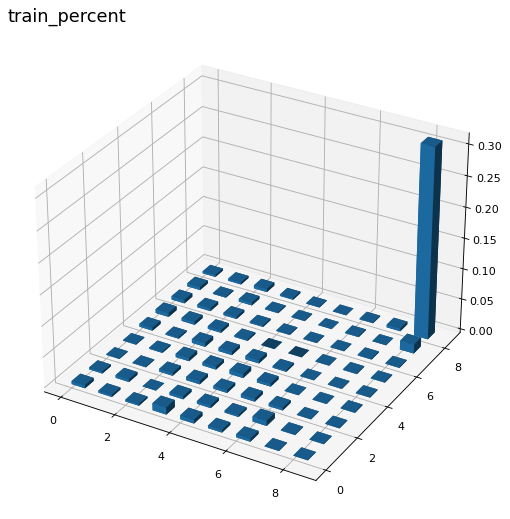

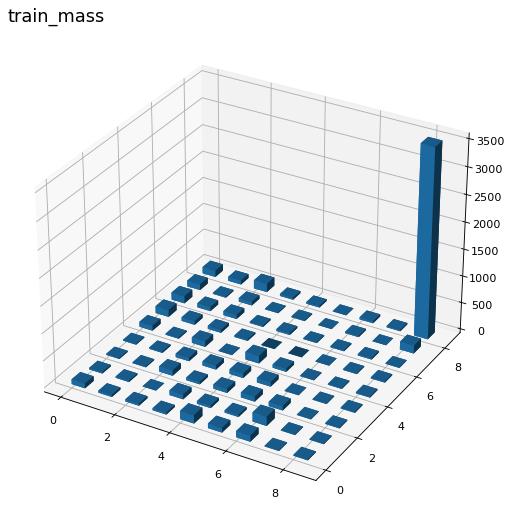

---predictions_test 65.24318838119507 seconds ---
best_cluster test =80


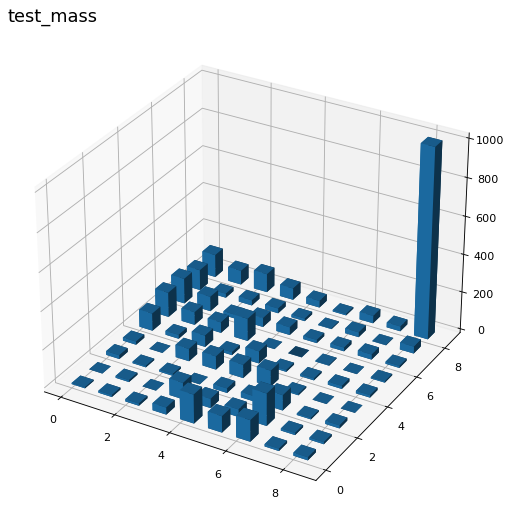

max_iter atteint
---training = 186.79997897148132 seconds ---
---predictions_train 139.7307047843933 seconds ---
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
best_cluster train =8


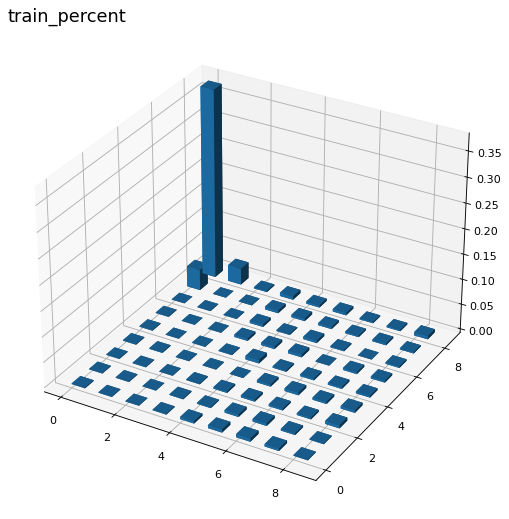

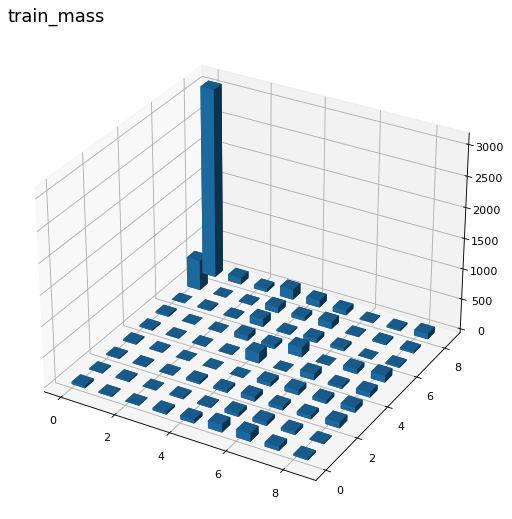

---predictions_test 65.82724952697754 seconds ---
best_cluster test =8


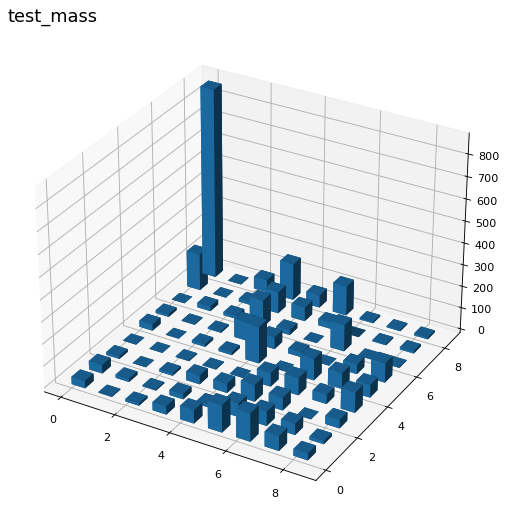

In [25]:
execution_SOM(saving_train,saving_test,Y_train ,Y_test,affichage="all")

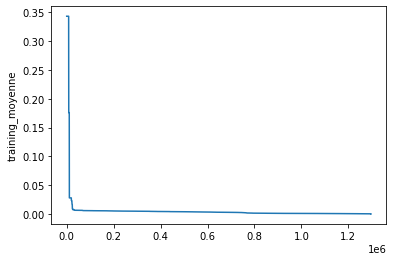

8283 values au dessus de 20% 
11349 values au dessus de 5% 
22322 values au dessus de 2% 


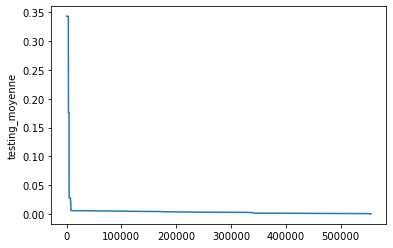

3024 values au dessus de 20% 
4330 values au dessus de 5% 
7485 values au dessus de 2% 


In [26]:
affiche_moyenne(saving_train,nombre_de_models,title="training_moyenne")
affiche_moyenne(saving_test,nombre_de_models,title="testing_moyenne")

In [48]:

#to read
#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.697.8197&rep=rep1&type=pdf

In [49]:
# assosier les pourcents de chaques donnée sachant son cluster
#percent contien le pourcent associé a chaques cluster
#prediction contien le cluster a qui appartien chaques donnée


In [50]:
#on va calculer un knonene ---> on a des cluster ---> on a des pourcents 
# on va utilise ce konenen sur les donnée val pour le atribuée des cluster 
# donc on peut leur attribuer des pourcents 
#on recomence 50 fois , et on fait la moyenne min 5 H d'execution
#


In [51]:
#etape de test
#test 1
#en premier j'ai testé mes data en trichant pour voir si ca faisait nimporte quoi
#j'ai train SOM_train sur Train
#j'ai executé SOM_train sur train ,calculer les % avec y_train,  affiche
#j'ai executé SOM_train sur test  ,calculer les % avec y_test ,  affiche
#les courbes etait tres similaires 
#a noter que je recalculais les % des cluster en utilisant y_test
# donc je ne doit pas m'en servir normalement
#test 2
#j'ai train SOM_train sur Train
#j'ai executé SOM_train sur train ,calculer les % avec y_train,  affiche
#j'ai executé SOM_train sur test  
# calculer les % avec les percent de cluster obtenu dans le training
#afficher
#c'est prometteur

In [ ]:
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


In [52]:
#ajout des percents dans xtrain et xtest 

In [53]:
moy= moyenne(saving_train,nombre_de_models)
moy=np.expand_dims(moy, axis=1)
X_train_transformed =np.concatenate((X_train_transformed,moy),axis=1)

moy= moyenne(saving_test,nombre_de_models)
moy=np.expand_dims(moy, axis=1)
X_test_transformed =np.concatenate((X_test_transformed,moy),axis=1)

In [55]:
arbre=DecisionTreeClassifier()

In [58]:
#training sur 32-7 colonnes

In [59]:
arbre.fit(xtrain_transformed_complique,ytrain_transformed_complique)
Y_train_pred=arbre.predict(xtrain_transformed_complique)
Y_test_pred=arbre.predict(xtest_transformed_complique)
print(classification_report(ytrain_transformed_complique,Y_train_pred))
print(classification_report(Y_test,Y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1031372
           1       1.00      1.00      1.00      5968

    accuracy                           1.00   1037340
   macro avg       1.00      1.00      1.00   1037340
weighted avg       1.00      1.00      1.00   1037340

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.73      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.86      0.84    555719
weighted avg       1.00      1.00      1.00    555719



In [60]:
#training sur 33-7 collonnes

In [61]:
moy= moyenne(saving_train,nombre_de_models)
xtrain_transformed_complique['percent']=moy[:len(xtrain_transformed_complique)]

moy= moyenne(saving_test,nombre_de_models)
xtest_transformed_complique['percent']=moy

In [62]:
arbre.fit(xtrain_transformed_complique,ytrain_transformed_complique)
Y_train_pred=arbre.predict(xtrain_transformed_complique)
Y_test_pred=arbre.predict(xtest_transformed_complique)
print(classification_report(ytrain_transformed_complique,Y_train_pred))
print(classification_report(Y_test,Y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1031372
           1       1.00      1.00      1.00      5968

    accuracy                           1.00   1037340
   macro avg       1.00      1.00      1.00   1037340
weighted avg       1.00      1.00      1.00   1037340

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.62      0.73      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.87      0.83    555719
weighted avg       1.00      1.00      1.00    555719



In [63]:
# test avec xgboost

In [65]:
#ignorer percent
print(np.shape(xtrain_transformed_complique))
print(type(xtrain_transformed_complique))
reduced_cols = [col for col in xtrain_transformed_complique if col!='percent']
print(np.shape(xtrain_transformed_complique[reduced_cols]))



(1037340, 25)
<class 'pandas.core.frame.DataFrame'>
(1037340, 24)


In [73]:
xgb = XGBClassifier(n_estimators=50, gamma=0.05,eta=0.05,max_depth=7, n_jobs=16)

xgb.fit(xtrain_transformed_complique[reduced_cols],ytrain_transformed_complique)
Y_train_pred=xgb.predict(xtrain_transformed_complique[reduced_cols])
Y_test_pred=xgb.predict(xtest_transformed_complique[reduced_cols])
print(classification_report(ytrain_transformed_complique,Y_train_pred))
print(classification_report(Y_test,Y_test_pred))

explainer = shap.TreeExplainer(xgb) 
shap_values = explainer.shap_values(xtest_transformed_complique[reduced_cols]) 
shap.summary_plot(shap_values, xtest_transformed_complique[reduced_cols], plot_type="bar")


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:10:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1031372
           1       0.96      0.72      0.82      5968

    accuracy                           1.00   1037340
   macro avg       0.98      0.86      0.91   1037340
weighted avg       1.00      1.00      1.00   1037340

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.68      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.84      0.89    555719
weighted avg       1.00      1.00      1.00    555719



ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

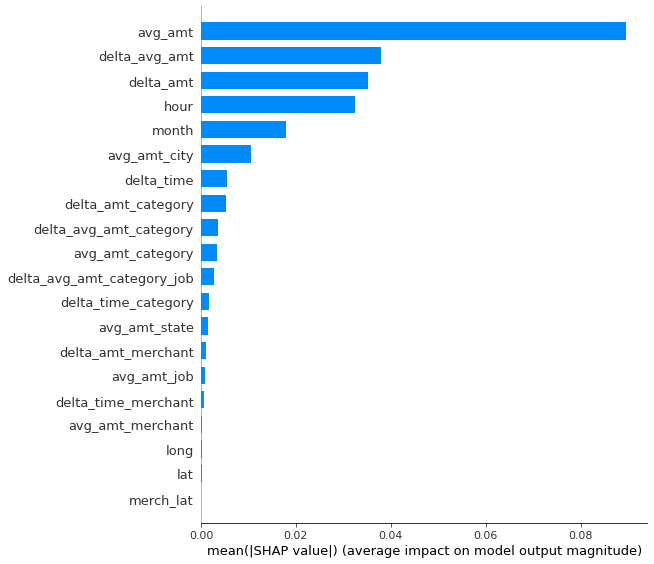

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:22:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1031372
           1       0.96      0.74      0.83      5968

    accuracy                           1.00   1037340
   macro avg       0.98      0.87      0.92   1037340
weighted avg       1.00      1.00      1.00   1037340

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.93      0.69      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.84      0.89    555719
weighted avg       1.00      1.00      1.00    555719



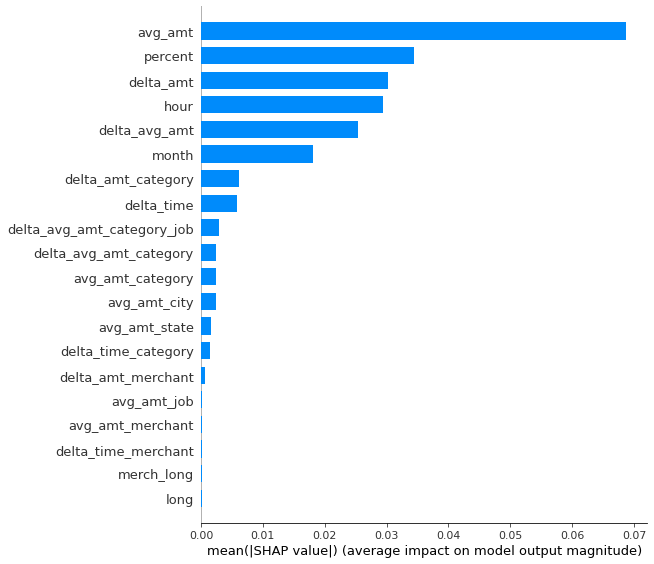

In [78]:
# ajout de percent

xgb.fit(xtrain_transformed_complique,ytrain_transformed_complique)
Y_train_pred=xgb.predict(xtrain_transformed_complique)
Y_test_pred=xgb.predict(xtest_transformed_complique)
print(classification_report(ytrain_transformed_complique,Y_train_pred))
print(classification_report(Y_test,Y_test_pred))

explainer = shap.TreeExplainer(xgb) 
shap_values = explainer.shap_values(xtest_transformed_complique) 
shap.summary_plot(shap_values, xtest_transformed_complique, plot_type="bar")


In [ ]:
#!pip install shap

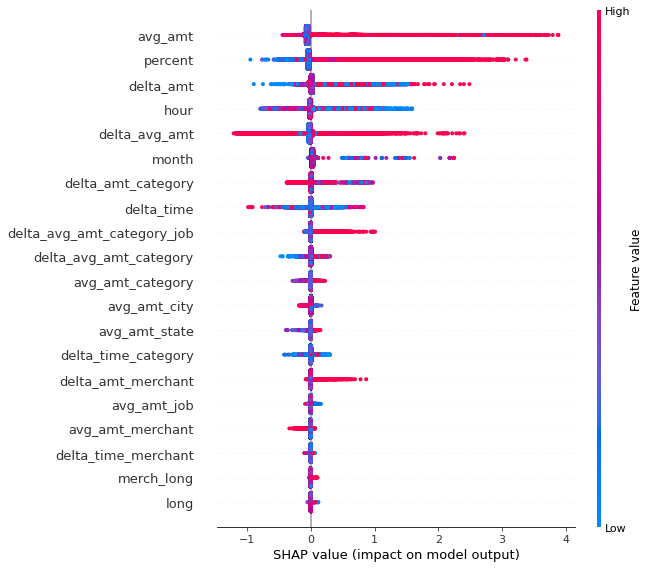

In [71]:
shap.summary_plot(shap_values, xtest_transformed_complique)



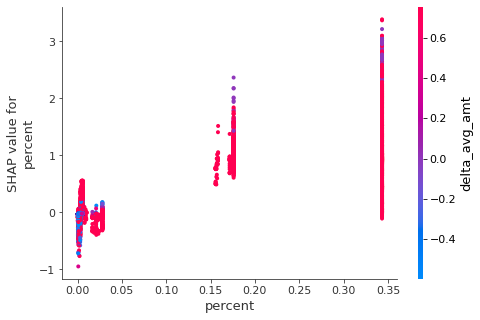

In [72]:
shap.dependence_plot("percent", shap_values, xtest_transformed_complique)



In [ ]:
# determiner si l'information que kononen done est redondante ou pas

In [ ]:
#silouhette score ou intra-distance ou wcss
#intra dist petit = bien

In [ ]:
#determinier si ca converge 


In [ ]:
#saving_test[num_model][% % % %]

In [74]:
m0 = np.mean(saving_test, axis=0)
print(m0.shape)
m1 = np.mean(saving_test, axis=1)
print(m1.shape)
std0=np.std(saving_test, axis=0)
print(std0.shape)
std1=np.std(saving_test, axis=1)
print(std1.shape)

(555719,)
(2,)
(555719,)
(2,)


In [76]:
print(m0)
print(m1)
print(std0)
print(std1)

[0.00093791 0.00098971 0.00299503 ... 0.00436566 0.00118589 0.00132906]
[0.00544634 0.00522711]
[1.94830290e-05 5.12010649e-05 6.19736000e-04 ... 7.98642505e-04
 5.41849725e-05 8.99294820e-04]
[0.02712882 0.02769158]


In [ ]:
#np.std(my_10_wcss) => stabilité
#np.mean(my_10_wcss) => qualié